In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import re

# Use this if running this notebook from within its place in the truera repository.
sys.path.insert(0, "..")
from collections import defaultdict
from IPython.display import display
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text 
import numpy as np
import collections

# Load as keras model

In [3]:
# tf.compat.v1.disable_eager_execution()

In [4]:
from tensorflow_hub.module_v2 import resolve
import tensorflow_models as tfm

/data/anaconda/envs/demo3/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [5]:
preprocessor_handle = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_handle = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2"

def load_tfhub_as_keras(handle):
    module_path = resolve(handle)
    return tf.keras.models.load_model(module_path)

preprocessor = load_tfhub_as_keras(preprocessor_handle)
encoder = load_tfhub_as_keras(encoder_handle).layers[-1]

2022-06-08 07:35:48.165333: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-08 07:35:48.758683: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20634 MB memory:  -> device: 0, name: NVIDIA A10G, pci bus id: 0000:00:1e.0, compute capability: 8.6


/data/anaconda/envs/demo3/lib/python3.9/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['masked_lm_positions'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [6]:
preprocessor.layers, encoder.layers

([<keras.engine.input_layer.InputLayer at 0x7ff0f20419d0>,
  <keras.layers.core.dense.Dense at 0x7ff04c7c39a0>])

## load existing checkpoint

In [7]:
def insert_layer_nonseq(model, layer_regex, insert_layer_factory,
                        insert_layer_name=None, position='after'):

    # Auxiliary dictionary to describe the network graph
    network_dict = {'input_layers_of': defaultdict(list), 'new_output_tensor_of': {}}

    # Set the input layers of each layer
    for layer in model.layers:
        for node in layer._outbound_nodes:
            layer_name = node.outbound_layer.name
            if layer.name not in network_dict['input_layers_of'][layer_name]:
                network_dict['input_layers_of'][layer_name].append(layer.name)

    # Set the output tensor of the input layer
    network_dict['new_output_tensor_of'].update(
            {model.layers[0].name: model.input})

    # Iterate over all layers after the input
    model_outputs = []
    for layer in model.layers[1:]:

        # Determine input tensors
        layer_input = [network_dict['new_output_tensor_of'][layer_aux] 
                for layer_aux in network_dict['input_layers_of'][layer.name]]
        if len(layer_input) == 1:
            layer_input = layer_input[0]

        # Insert layer if name matches the regular expression
        if re.match(layer_regex, layer.name):
            if position == 'replace':
                x = layer_input
            elif position == 'after':
                x = layer(layer_input)
            elif position == 'before':
                pass
            else:
                raise ValueError('position must be: before, after or replace')

            new_layer = insert_layer_factory()
            x = new_layer(x)
            print('New layer: {} Old layer: {} Type: {}'.format(new_layer.name,
                                                            layer.name, position))
            if position == 'before':
                x = layer(x)
        else:
            x = layer(layer_input)

        # Set new output tensor (the original one, or the one of the inserted
        # layer)
        network_dict['new_output_tensor_of'].update({layer.name: x})

        # Save tensor in output list if it is output in initial model
        if layer.name in model.output_names:
            model_outputs.append(x)

    return tf.keras.Model(inputs=model.inputs, outputs=model_outputs)

In [8]:
model = tf.keras.models.load_model('/data/longterm/kaggle-covid-tweets/model/classifierbert-cnn')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [9]:
# model = insert_layer_nonseq(model, "preprocessing", lambda: preprocessor, position='replace')

In [10]:
# insert_layer_nonseq(model, "BERT_encoder", lambda: encoder, 'replace')

In [11]:
def model_weight_reassign(keras_layer, keras_module):
    # ensure trainable_variables line up
    assert False not in [w1.name == w2.name for w1, w2 in zip(keras_layer.trainable_weights, keras_module.trainable_weights)]
    for orig_weight, module_weight in zip(keras_layer.trainable_weights, keras_module.trainable_weights):
        val = tf.keras.backend.get_value(orig_weight)
        tf.keras.backend.set_value(module_weight, val)
    

In [12]:
(model.layers[2].trainable_weights[0].numpy() == encoder.trainable_weights[0].numpy()).all()

False

In [13]:
model_weight_reassign(model.layers[2], encoder)

In [14]:
(model.layers[2].trainable_weights[0].numpy() == encoder.trainable_weights[0].numpy()).all()

True

## Model Plots

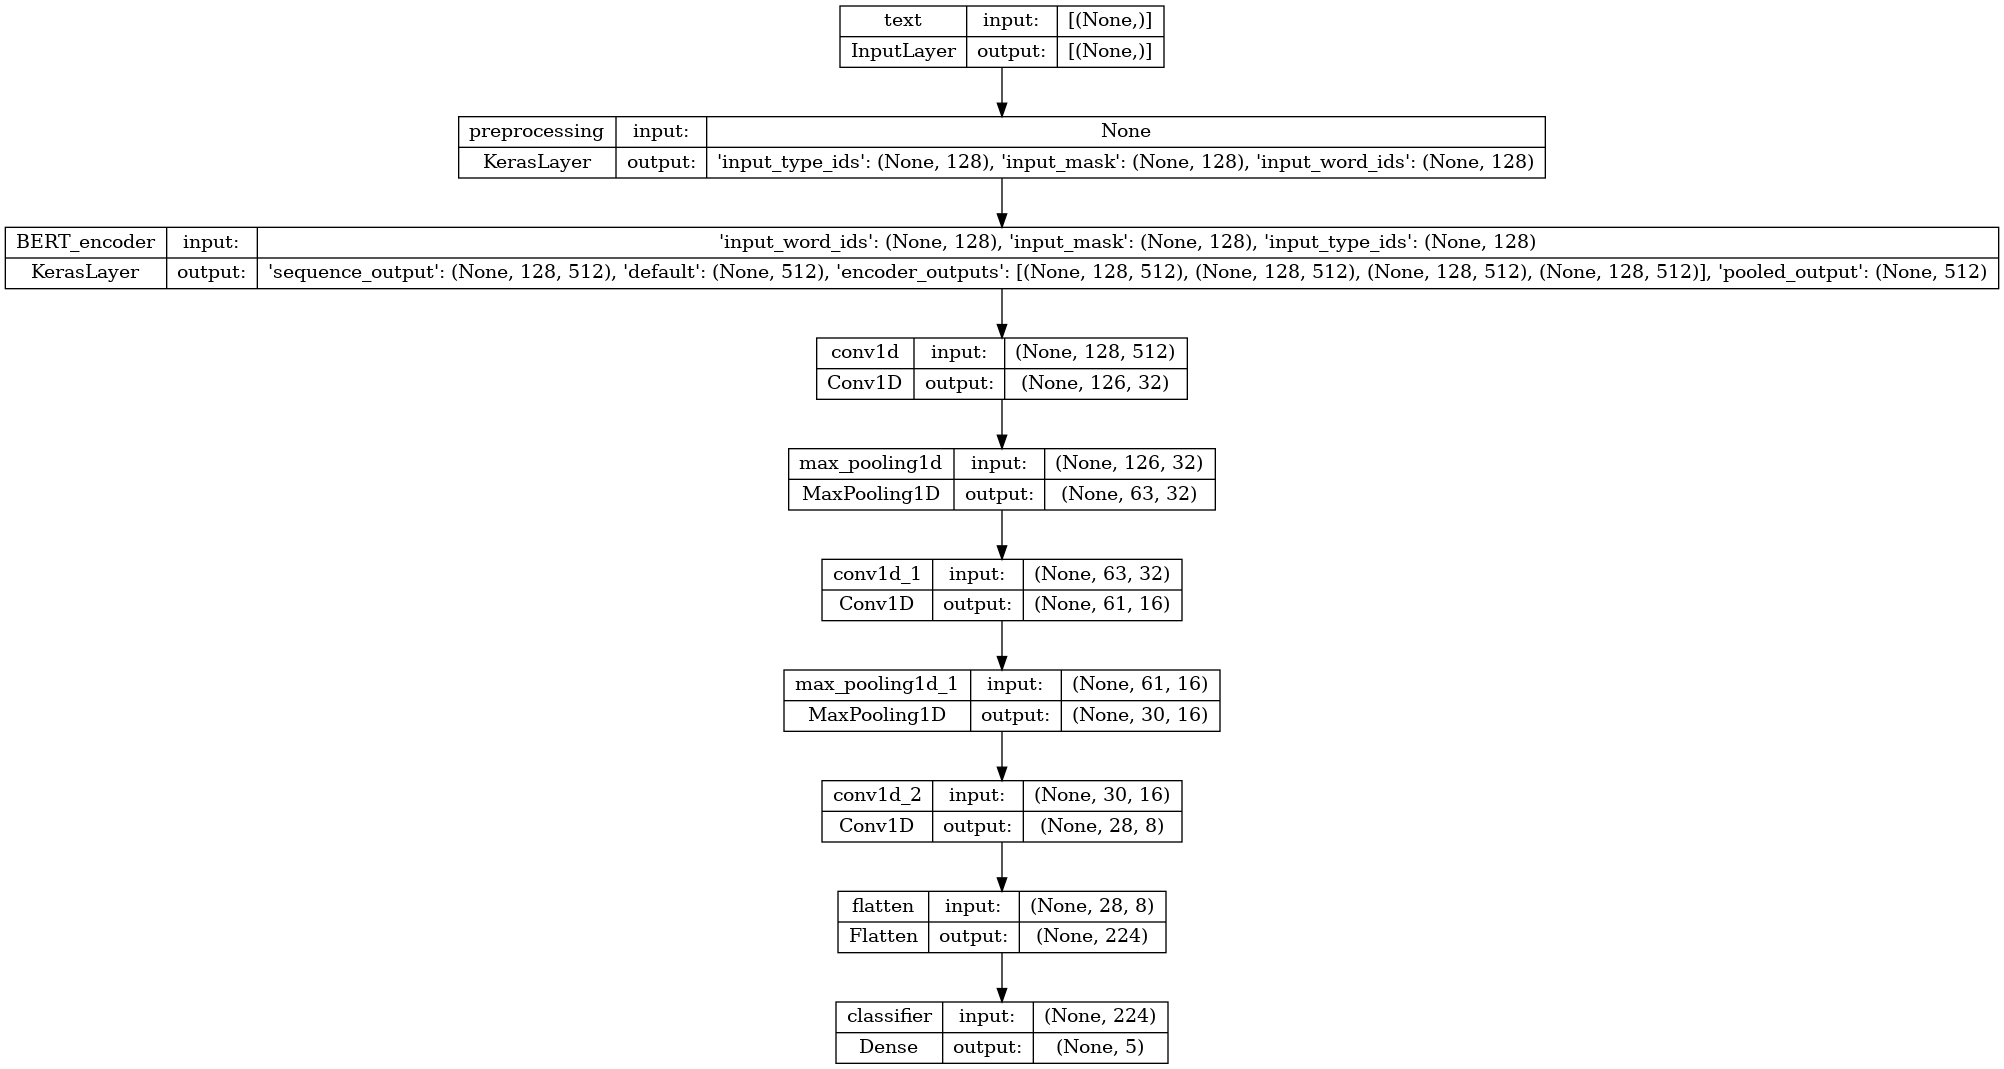

In [15]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

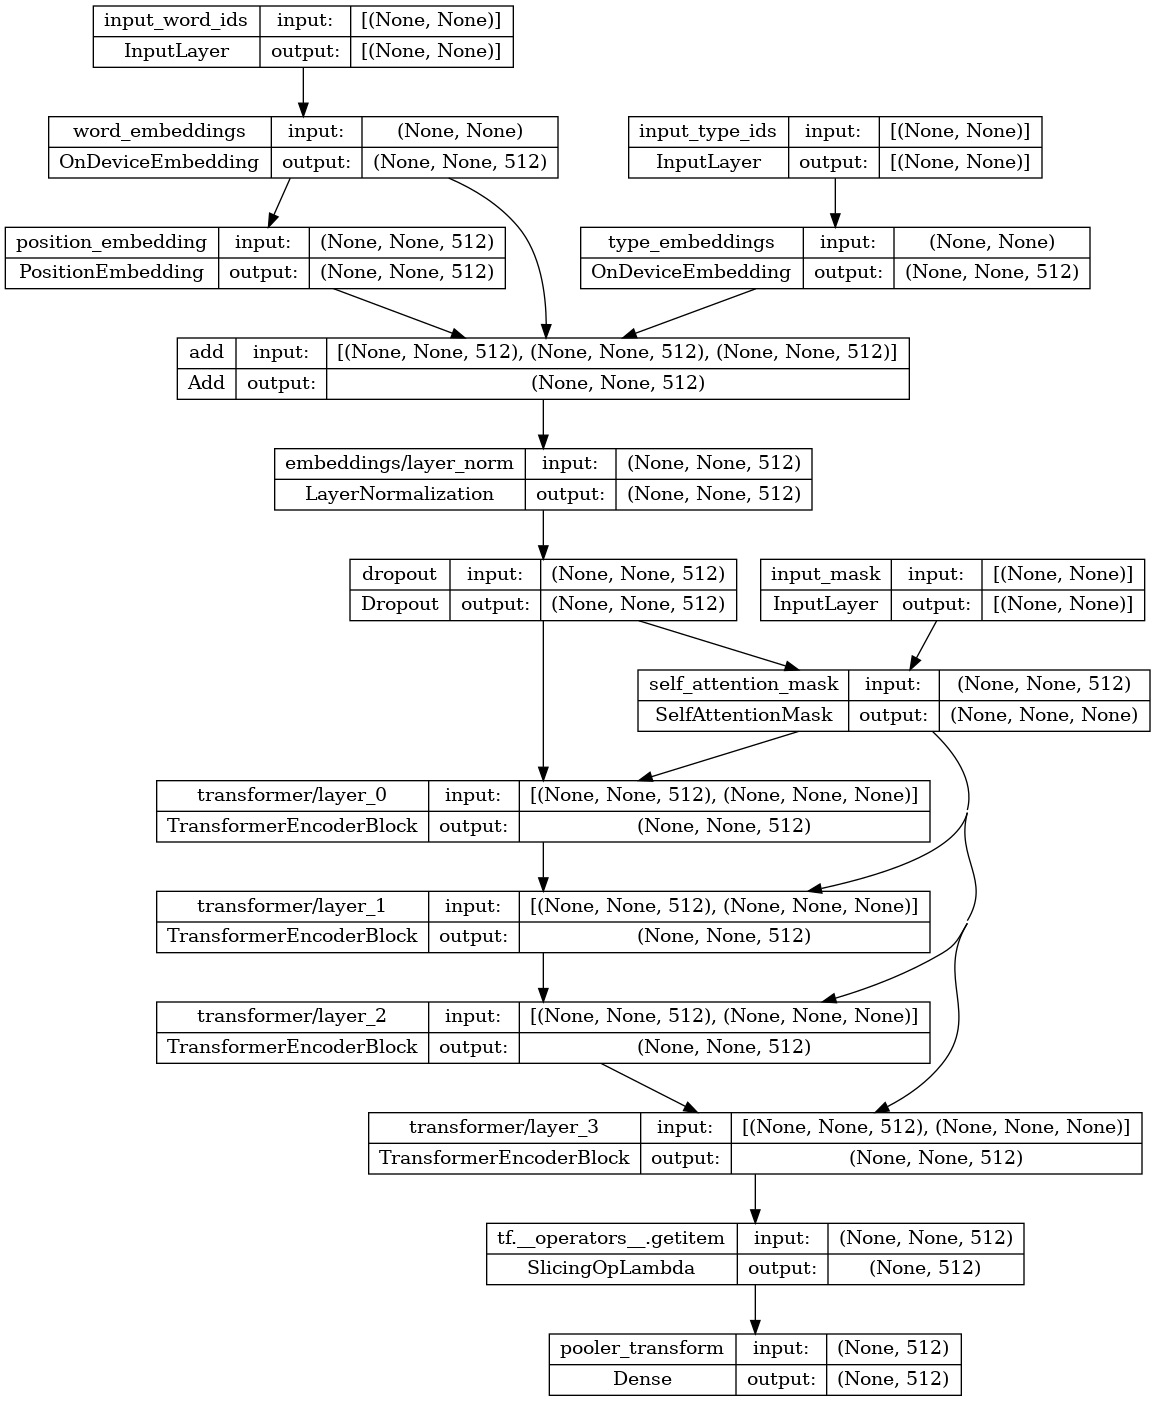

In [16]:
plot_model(encoder, show_shapes=True, show_layer_names=True)

## GradientTape on layer outputs

In [17]:
encoder_layer_names = {l.name: l for l in encoder.layers}
encoder_layer_names

{'input_word_ids': <keras.engine.input_layer.InputLayer at 0x7ff06c293130>,
 'word_embeddings': <official.nlp.modeling.layers.on_device_embedding.OnDeviceEmbedding at 0x7ff06c2c96a0>,
 'input_type_ids': <keras.engine.input_layer.InputLayer at 0x7ff06c2c9340>,
 'position_embedding': <official.nlp.modeling.layers.position_embedding.PositionEmbedding at 0x7ff06c2c9880>,
 'type_embeddings': <official.nlp.modeling.layers.on_device_embedding.OnDeviceEmbedding at 0x7ff06c2c9640>,
 'add': <keras.layers.merging.add.Add at 0x7ff06c2e7c70>,
 'embeddings/layer_norm': <keras.layers.normalization.layer_normalization.LayerNormalization at 0x7ff06c2226a0>,
 'dropout': <keras.layers.regularization.dropout.Dropout at 0x7ff06c195040>,
 'input_mask': <keras.engine.input_layer.InputLayer at 0x7ff06c293fa0>,
 'self_attention_mask': <official.nlp.modeling.layers.self_attention_mask.SelfAttentionMask at 0x7ff06c1958e0>,
 'transformer/layer_0': <official.nlp.modeling.layers.transformer_encoder_block.Transforme

In [18]:
model_layer_names = {l.name: l for l in model.layers}
model_layer_names

{'text': <keras.engine.input_layer.InputLayer at 0x7feafc9d2c10>,
 'preprocessing': <keras.saving.saved_model.load.KerasLayer at 0x7feafca86e20>,
 'BERT_encoder': <keras.saving.saved_model.load.KerasLayer at 0x7feafca86d60>,
 'conv1d': <keras.layers.convolutional.conv1d.Conv1D at 0x7feafca86f10>,
 'max_pooling1d': <keras.layers.pooling.max_pooling1d.MaxPooling1D at 0x7ff04c707f10>,
 'conv1d_1': <keras.layers.convolutional.conv1d.Conv1D at 0x7feafcc468b0>,
 'max_pooling1d_1': <keras.layers.pooling.max_pooling1d.MaxPooling1D at 0x7feafc9d0c70>,
 'conv1d_2': <keras.layers.convolutional.conv1d.Conv1D at 0x7feafc9d0820>,
 'flatten': <keras.layers.reshaping.flatten.Flatten at 0x7feafd971130>,
 'classifier': <keras.layers.core.dense.Dense at 0x7feafd9e0f70>}

In [19]:
encoder.output

{'sequence_output': <KerasTensor: shape=(None, None, 512) dtype=float32 (created by layer 'transformer/layer_3')>,
 'pooled_output': <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'pooler_transform')>,
 'encoder_outputs': [<KerasTensor: shape=(None, None, 512) dtype=float32 (created by layer 'transformer/layer_0')>,
  <KerasTensor: shape=(None, None, 512) dtype=float32 (created by layer 'transformer/layer_1')>,
  <KerasTensor: shape=(None, None, 512) dtype=float32 (created by layer 'transformer/layer_2')>,
  <KerasTensor: shape=(None, None, 512) dtype=float32 (created by layer 'transformer/layer_3')>]}

In [20]:
word_embedding_output_tensor = encoder.layers[1].output
word_embedding_output_tensor

<KerasTensor: shape=(None, None, 512) dtype=float32 (created by layer 'word_embeddings')>

In [21]:
post_embedding_model = tf.keras.Model(
    inputs=[word_embedding_output_tensor, encoder_layer_names['input_type_ids'].input, encoder_layer_names['input_mask'].input], 
    outputs=encoder.output['sequence_output']
)

In [22]:
test_constant = tf.constant(["word one word two", "another sentence to compare against"])
with tf.GradientTape() as tape:
    enc_input = preprocessor(test_constant)
    
    word_embedding_tensor = encoder.layers[1](enc_input['input_word_ids'])
    tape.watch(word_embedding_tensor)

    outputs = post_embedding_model([word_embedding_tensor, enc_input['input_type_ids'], enc_input['input_mask']])

    # outputs = encoder(enc_input)
    # output = tf.reduce_sum(outputs['sequence_output'])

gradients = tape.gradient(outputs, word_embedding_tensor)
gradients

2022-06-08 07:36:08.160353: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


<tf.Tensor: shape=(2, 128, 512), dtype=float32, numpy=
array([[[-2.35302258e+01,  8.86870384e+00,  7.68673897e+00, ...,
          2.74800563e+00, -8.71699429e+00,  2.45719004e+00],
        [-2.14117947e+01,  4.09604607e+01, -4.24357452e+01, ...,
          1.06120050e+00, -3.40362663e+01, -7.62129593e+00],
        [-1.15976992e+01,  2.18188934e+01, -6.42701912e+00, ...,
          7.39400959e+00, -1.13035030e+01, -1.64940929e+01],
        ...,
        [ 5.02356827e-01,  1.98667124e-01, -3.01021159e-01, ...,
         -4.39087301e-03, -2.25818440e-01,  9.81237963e-02],
        [ 4.15651113e-01, -4.85871360e-03, -1.09806314e-01, ...,
          3.05328891e-03, -2.63953239e-01, -4.31704288e-03],
        [ 5.95008016e-01, -9.65791196e-03, -3.47437263e-01, ...,
          1.43042952e-02, -4.73970413e-01,  2.54449368e-01]],

       [[-2.71109734e+01, -1.19902539e+00,  3.07619095e+00, ...,
          1.29897442e+01, -2.06306152e+01,  2.45621910e+01],
        [-3.87126274e+01,  7.52465820e+00, -1.28

# Inject model layer

In [23]:
def recurse_outputs(obj, prefix=[]):
    ret = {}
    if tf.is_tensor(obj):
        return {obj.ref(): prefix}
    elif isinstance(obj, collections.abc.Mapping):
        for key, val in obj.items():
            ret.update(recurse_outputs(val, prefix + [key]))
    elif isinstance(obj, collections.abc.Iterable):
        for i, elem in enumerate(obj):
            ret.update(recurse_outputs(elem, prefix + [i]))
    else:
        print(type(obj))
    return ret

In [24]:
tensor_mapping = recurse_outputs(model.layers[2].inbound_nodes[0].outputs)
tensor_mapping

{<Reference wrapping <KerasTensor: shape=(None, 128, 512) dtype=float32 (created by layer 'BERT_encoder')>>: ['sequence_output'],
 <Reference wrapping <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'BERT_encoder')>>: ['default'],
 <Reference wrapping <KerasTensor: shape=(None, 128, 512) dtype=float32 (created by layer 'BERT_encoder')>>: ['encoder_outputs',
  0],
 <Reference wrapping <KerasTensor: shape=(None, 128, 512) dtype=float32 (created by layer 'BERT_encoder')>>: ['encoder_outputs',
  1],
 <Reference wrapping <KerasTensor: shape=(None, 128, 512) dtype=float32 (created by layer 'BERT_encoder')>>: ['encoder_outputs',
  2],
 <Reference wrapping <KerasTensor: shape=(None, 128, 512) dtype=float32 (created by layer 'BERT_encoder')>>: ['encoder_outputs',
  3],
 <Reference wrapping <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'BERT_encoder')>>: ['pooled_output']}

In [25]:
list(tensor_mapping.keys())[0]

<Reference wrapping <KerasTensor: shape=(None, 128, 512) dtype=float32 (created by layer 'BERT_encoder')>>

In [26]:
model.layers[-2].inbound_nodes[0].__dict__

{'layer': <keras.layers.reshaping.flatten.Flatten at 0x7feafd971130>,
 'is_input': False,
 'outputs': <KerasTensor: shape=(None, 224) dtype=float32 (created by layer 'flatten')>,
 'call_args': (<KerasTensor: shape=(None, 28, 8) dtype=float32 (created by layer 'conv1d_2')>,),
 'call_kwargs': {},
 '_flat_arguments': [<KerasTensor: shape=(None, 28, 8) dtype=float32 (created by layer 'conv1d_2')>],
 '_single_positional_tensor_passed': True,
 '_keras_inputs': [<KerasTensor: shape=(None, 28, 8) dtype=float32 (created by layer 'conv1d_2')>],
 '_keras_inputs_ids_and_indices': [('140647123683984', 0)],
 'flat_input_ids': ['140647123683984'],
 'flat_output_ids': ['140647123474272']}

In [27]:
model.layers[-1].inbound_nodes[0].__dict__

{'layer': <keras.layers.core.dense.Dense at 0x7feafd9e0f70>,
 'is_input': False,
 'outputs': <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'classifier')>,
 'call_args': (<KerasTensor: shape=(None, 224) dtype=float32 (created by layer 'flatten')>,),
 'call_kwargs': {},
 '_flat_arguments': [<KerasTensor: shape=(None, 224) dtype=float32 (created by layer 'flatten')>],
 '_single_positional_tensor_passed': True,
 '_keras_inputs': [<KerasTensor: shape=(None, 224) dtype=float32 (created by layer 'flatten')>],
 '_keras_inputs_ids_and_indices': [('140647123474272', 0)],
 'flat_input_ids': ['140647123474272'],
 'flat_output_ids': ['140647123867440']}

In [28]:
def get_layer_input_paths(model):
    layer_outputs = {}
    layer_input_paths = {}
    
    # Outputs of each layer
    for layer in model.layers:
        layer_outputs[layer.name] = recurse_outputs(layer.output, [layer.name])

    # Path to inputs of each layer
    for layer in model.layers:
        out_nodes = set(layer.outbound_nodes)
        for out_node in out_nodes:
            next_layer = out_node.layer
            args = out_node.call_args
            kwargs = out_node.call_kwargs
            
            arg_paths = []
            for i, arg in enumerate(args):
                if tf.is_tensor(arg):
                    arg_path = layer_outputs[layer.name][arg.ref()]
                elif isinstance(arg, collections.abc.Mapping):
                    arg_path = {key: layer_outputs[layer.name][arg.ref()] for key, arg in arg.items()}
                elif isinstance(arg, collections.abc.Iterable):
                    arg_path = [layer_outputs[layer.name][arg.ref()] for j, arg in enumerate(arg)]
                arg_paths.append(arg_path)

            kwarg_paths = {}
            for key, arg in kwargs.items():
                kwarg_paths[key] = {}
                if tf.is_tensor(arg):
                    kwarg_paths[key] = layer_outputs[layer.name][arg.ref()]
                elif isinstance(arg, collections.abc.Mapping):
                    kwarg_paths[key] = {key: layer_outputs[layer.name][arg.ref()] for key, arg in arg.items()}
                elif isinstance(arg, collections.abc.Iterable):
                    kwarg_paths[key] = [layer_outputs[layer.name][arg.ref()] for arg in arg]
            
            if next_layer.name not in layer_input_paths:
                layer_input_paths[next_layer.name] = {"args": arg_paths, "kwargs": kwarg_paths}
            else:
                layer_input_paths[next_layer.name]['args'].extend(arg_paths) 
                layer_input_paths[next_layer.name]['kwargs'].update(kwarg_paths) 
        
    return layer_input_paths

layer_input_paths = get_layer_input_paths(model)
layer_input_paths

{'preprocessing': {'args': [['text']], 'kwargs': {}},
 'BERT_encoder': {'args': [{'input_word_ids': ['preprocessing',
     'input_word_ids'],
    'input_mask': ['preprocessing', 'input_mask'],
    'input_type_ids': ['preprocessing', 'input_type_ids']}],
  'kwargs': {}},
 'conv1d': {'args': [['BERT_encoder', 'sequence_output']], 'kwargs': {}},
 'max_pooling1d': {'args': [['conv1d']], 'kwargs': {}},
 'conv1d_1': {'args': [['max_pooling1d']], 'kwargs': {}},
 'max_pooling1d_1': {'args': [['conv1d_1']], 'kwargs': {}},
 'conv1d_2': {'args': [['max_pooling1d_1']], 'kwargs': {}},
 'flatten': {'args': [['conv1d_2']], 'kwargs': {}},
 'classifier': {'args': [['flatten']], 'kwargs': {}}}

In [29]:
def lookup_arg_path(path, model, layer_subs=None):
    layer_name = path[0]
    
    if layer_subs and layer_name in layer_subs:
        out = layer_subs[layer_name]
    else:
        model_layer_names = {l.name: l for l in model.layers}
        layer = model_layer_names[layer_name]
        out = layer.output

    for part in path[1:]:
        if isinstance(out, collections.abc.Mapping):
            out = out[part]
        elif isinstance(part, int) and isinstance(out, collections.abc.Iterable):
            out = out[part]
        else:
            raise ValueError(f"Invalid part path {part} for object {out}")
    return out


In [30]:
def get_layer_exec_order(nodes_by_depth):
    layer_paths = {}
    def helper(depth=0):
        if depth not in nodes_by_depth:
            return
        else:
            for node in nodes_by_depth[depth]:
                inbound_layers = node.inbound_layers

                if isinstance(inbound_layers, list):
                    inbound_layers = list(set(inbound_layers))
                else:
                    inbound_layers = [inbound_layers]

                for layer in inbound_layers:
                    if node.outbound_layer in layer_paths:
                        layer_paths[layer] = [node.outbound_layer] + layer_paths[node.outbound_layer]
                    else:
                        layer_paths[layer] = [node.outbound_layer]
            helper(depth=depth+1)
    helper()
    return layer_paths
layer_exec_order = get_layer_exec_order(model._nodes_by_depth)
layer_exec_order

{<keras.layers.reshaping.flatten.Flatten at 0x7feafd971130>: [<keras.layers.core.dense.Dense at 0x7feafd9e0f70>],
 <keras.layers.convolutional.conv1d.Conv1D at 0x7feafc9d0820>: [<keras.layers.reshaping.flatten.Flatten at 0x7feafd971130>,
 <keras.layers.pooling.max_pooling1d.MaxPooling1D at 0x7feafc9d0c70>: [<keras.layers.convolutional.conv1d.Conv1D at 0x7feafc9d0820>,
 <keras.layers.convolutional.conv1d.Conv1D at 0x7feafcc468b0>: [<keras.layers.pooling.max_pooling1d.MaxPooling1D at 0x7feafc9d0c70>,
 <keras.layers.pooling.max_pooling1d.MaxPooling1D at 0x7ff04c707f10>: [<keras.layers.convolutional.conv1d.Conv1D at 0x7feafcc468b0>,
 <keras.layers.convolutional.conv1d.Conv1D at 0x7feafca86f10>: [<keras.layers.pooling.max_pooling1d.MaxPooling1D at 0x7ff04c707f10>,
 <keras.saving.saved_model.load.KerasLayer at 0x7feafca86d60>: [<keras.layers.convolutional.conv1d.Conv1D at 0x7feafca86f10>,
 <keras.saving.saved_model.load.KerasLayer at 0x7feafca86e20>: [<keras.saving.saved_model.load.KerasLaye

In [39]:
def get_layer_input_tensors(layer, model, layer_subs=None):
    layer_name = layer.name
    input_paths = layer_input_paths[layer_name]
    args = input_paths['args']
    kwargs = input_paths['kwargs']


    # fetch input args for this layer
    input_args = []
    for arg in args:
        if isinstance(arg, collections.abc.Mapping):
            input_args.append({k: lookup_arg_path(path, model, layer_subs) for k, path in arg.items()})
        elif isinstance(arg, collections.abc.Iterable):
            if len(arg) <= 0:
                pass
            elif isinstance(arg[0], str):
                # one path
                input_args.append(lookup_arg_path(arg, model, layer_subs))
            elif isinstance(arg[0], collections.abc.Iterable):
                 input_args.append([lookup_arg_path(path, model, layer_subs) for path in arg])
    input_args = tuple(input_args)

    input_kwargs = {}
    for key, arg in kwargs.items():
        if isinstance(arg, collections.abc.Mapping):
            input_kwargs[key] = {k: lookup_arg_path(path, model, layer_subs) for k, path in arg.items()}
        elif isinstance(arg, collections.abc.Iterable):
            if len(arg) <= 0:
                pass
            elif isinstance(arg[0], str):
                # one path
                input_kwargs[key] = lookup_arg_path(arg, model, layer_subs)
            elif isinstance(arg[0], collections.abc.Iterable):
                 input_kwargs[key] = [lookup_arg_path(path, model, layer_subs) for path in arg]
    
    return input_args, input_kwargs


def replace_layer(layer, model, replacement):
    input_args, input_kwargs = get_layer_input_tensors(layer, model)
    output = replacement(*input_args, **input_kwargs)
    prev_layer = replacement

    next_layers = layer_exec_order[layer]
    print([l.name for l in next_layers])

    for next_layer in next_layers:
        input_args, input_kwargs = get_layer_input_tensors(next_layer, model, layer_subs={prev_layer.name: output})
        output = next_layer(*input_args, **input_kwargs)
        
        prev_layer = next_layer
    
    return tf.keras.Model(inputs=model.inputs, outputs=output)


In [40]:
new_model = replace_layer(model.layers[2], model, encoder)

['conv1d', 'max_pooling1d', 'conv1d_1', 'max_pooling1d_1', 'conv1d_2', 'flatten', 'classifier']


In [46]:
test_input = tf.constant(["this is a new word"])
(new_model(test_input) == model(test_input)).numpy().all()

True

# Load from checkpoint

In [3]:
tf.compat.v1.disable_eager_execution()

In [4]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])


In [5]:
model = tf.keras.models.load_model('/data/longterm/kaggle-covid-tweets/model/classifierbert-cnn')

2022-06-05 09:36:44.853260: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-05 09:36:45.778340: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20634 MB memory:  -> device: 0, name: NVIDIA A10G, pci bus id: 0000:00:1e.0, compute capability: 8.6
2022-06-05 09:36:45.927385: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


In [6]:
# preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
# encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=True)
preprocessor = model.layers[1]
encoder = model.layers[2]
preprocessor, encoder

(<keras.saving.saved_model.load.KerasLayer at 0x7f4ff3364070>,
 <keras.saving.saved_model.load.KerasLayer at 0x7f4ff3364850>)

In [7]:
test_input = tf.constant(["word one word two"])
encoder_input = preprocessor(test_input)
encoder_input

{'input_type_ids': <tf.Tensor 'preprocessing_1/cond/Identity_1:0' shape=(1, 128) dtype=int32>,
 'input_word_ids': <tf.Tensor 'preprocessing_1/cond/Identity_2:0' shape=(1, 128) dtype=int32>,
 'input_mask': <tf.Tensor 'preprocessing_1/cond/Identity:0' shape=(1, 128) dtype=int32>}

In [8]:
# node of interest
# op_name = "model/bert_encoder/word_embeddings/Gather"
# op_name = "model/bert_encoder/word_embeddings/Reshape_1"
op_name = "word_embeddings/Reshape_1"
tensor_name = f"{op_name}:0"
op_name, tensor_name

graph = model.signatures['serving_default'].graph

func = [func for func in graph._functions.values() if func.graph.name == "bert_encoder_layer_call_and_return_conditional_losses"][0]
func_graph = func.graph

embedding_output_tensor = func_graph.get_tensor_by_name(tensor_name)
seq_output_tensor = func_graph.outputs[-1]

embedding_output_tensor, seq_output_tensor 

(<tf.Tensor 'word_embeddings/Reshape_1:0' shape=(None, None, 512) dtype=float32>,
 <tf.Tensor 'Identity_5:0' shape=(None, None, 512) dtype=float32>)

In [9]:
# gradient op
grad_op = tf.gradients(seq_output_tensor, embedding_output_tensor, [embedding_output_tensor])

In [10]:
model

In [11]:
# encoder_graph = model.layers[2]._autographed_call().trace_0.graph
# with encoder_graph.as_default():
#     writer = tf.compat.v1.summary.FileWriter("enc_output", encoder_graph)

In [12]:
embedding_matrix = model.layers[2].trainable_weights[0]
embedding_matrix.shape

TensorShape([30522, 512])

In [13]:
operations = func_graph.get_operations() 
operations

[<tf.Operation 'inputs' type=Placeholder>,
 <tf.Operation 'inputs_1' type=Placeholder>,
 <tf.Operation 'inputs_2' type=Placeholder>,
 <tf.Operation 'word_embeddings_gather_resource' type=Placeholder>,
 <tf.Operation 'position_embedding_readvariableop_resource' type=Placeholder>,
 <tf.Operation 'type_embeddings_matmul_readvariableop_resource' type=Placeholder>,
 <tf.Operation 'embeddings_layer_norm_batchnorm_mul_readvariableop_resource' type=Placeholder>,
 <tf.Operation 'embeddings_layer_norm_batchnorm_readvariableop_resource' type=Placeholder>,
 <tf.Operation 'transformer_layer_0_self_attention_query_einsum_einsum_readvariableop_resource' type=Placeholder>,
 <tf.Operation 'transformer_layer_0_self_attention_query_add_readvariableop_resource' type=Placeholder>,
 <tf.Operation 'transformer_layer_0_self_attention_key_einsum_einsum_readvariableop_resource' type=Placeholder>,
 <tf.Operation 'transformer_layer_0_self_attention_key_add_readvariableop_resource' type=Placeholder>,
 <tf.Operatio

# GradientTape on main graph tensors

In [25]:
with tf.GradientTape() as tape:
    # Forward pass.
    t = tf.compat.v1.get_default_graph().get_tensor_by_name("Identity_82:0")
    # embedding_output_tensor, seq_output_tensor
    tape.watch(t)
    
    outputs = model(test_input)
    output = tf.reduce_sum(outputs)

# Get gradients of the loss wrt the weights.
gradients = tape.gradient(output, t)


In [30]:
gradients is None

True

# GradientTape on local KerasLayer function graph tensors

In [31]:
with tf.GradientTape() as tape:
    # Forward pass.
    # embedding_output_tensor, seq_output_tensor
    tape.watch(embedding_output_tensor)
    
    encoder(preprocessor(tf.constant(["word one word two"])))

    outputs = model(test_input)
    output = tf.reduce_sum(outputs)

# Get gradients of the loss wrt the weights.
gradients = tape.gradient(output, embedding_output_tensor)


In [33]:
gradients

In [35]:
out_tensor = model._run_internal_graph(tf.constant(["number one"]))
def traverse(tensor):
    print(tensor.name)
    if not tensor.op:
        return
    elif tensor.op.inputs:
        for i in tensor.op.inputs:
            traverse(i)
traverse(out_tensor)

classifier_3/Softmax:0
classifier_3/BiasAdd:0
classifier_3/MatMul:0
flatten_3/Reshape:0
conv1d_2_3/Relu:0
conv1d_2_3/BiasAdd:0
conv1d_2_3/Conv1D/Squeeze:0
conv1d_2_3/Conv1D:0
conv1d_2_3/Conv1D/ExpandDims:0
max_pooling1d_1_3/Squeeze:0
max_pooling1d_1_3/MaxPool:0
max_pooling1d_1_3/ExpandDims:0
conv1d_1_3/Relu:0
conv1d_1_3/BiasAdd:0
conv1d_1_3/Conv1D/Squeeze:0
conv1d_1_3/Conv1D:0
conv1d_1_3/Conv1D/ExpandDims:0
max_pooling1d_4/Squeeze:0
max_pooling1d_4/MaxPool:0
max_pooling1d_4/ExpandDims:0
conv1d_5/Relu:0
conv1d_5/BiasAdd:0
conv1d_5/Conv1D/Squeeze:0
conv1d_5/Conv1D:0
conv1d_5/Conv1D/ExpandDims:0
BERT_encoder_5/cond/Identity_6:0
BERT_encoder_5/cond:6
keras_learning_phase:0
keras_learning_phase/input:0
preprocessing_6/cond/Identity:0
preprocessing_6/cond:0
keras_learning_phase:0
keras_learning_phase/input:0
Const_12:0
StatefulPartitionedCall:0
Const:0
preprocessing_6/cond/Identity_1:0
preprocessing_6/cond:1
keras_learning_phase:0
keras_learning_phase/input:0
Const_12:0
StatefulPartitionedCa

# Execution tf.gradients op

In [26]:
init = tf.compat.v1.global_variables_initializer()

with tf.compat.v1.Session() as sess:
    sess.run(init)
    sess.run(tf.compat.v1.tables_initializer())

    word_ids = encoder_input['input_word_ids'].eval()
    embedding_matrix_vals = embedding_matrix.eval()
    word_embedding_vals = tf.gather(embedding_matrix_vals, word_ids).eval()

with tf.compat.v1.Session() as sess:
    feed_dict = {embedding_output_tensor.name: word_embedding_vals}
    sess.run(grad_op, feed_dict=feed_dict)
    # model(tf.constant(["word one word two"]))
    # indices = gradients.indices.eval()
    # values = gradients.values.eval()

2022-06-05 09:19:50.916670: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20634 MB memory:  -> device: 0, name: NVIDIA A10G, pci bus id: 0000:00:1e.0, compute capability: 8.6
2022-06-05 09:19:56.963227: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20634 MB memory:  -> device: 0, name: NVIDIA A10G, pci bus id: 0000:00:1e.0, compute capability: 8.6


TypeError: Cannot interpret feed_dict key as Tensor: The name 'word_embeddings/Reshape_1:0' refers to a Tensor which does not exist. The operation, 'word_embeddings/Reshape_1', does not exist in the graph.

In [2]:
values = np.load("values.npy")
indices = np.load("indices.npy")
we_outputs = np.load("we_outputs.npy")

In [5]:
we_outputs

array([( 96,), (104,), (145,), ( 59,), (115,), ( 85,), (  0,), (  0,),
       ( 44,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,),
       ( 44,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,),
       (  0,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,),
       ( 48,), (253,), (111,), ( 60,), (115,), ( 85,), (  0,), (  0,),
       (  9,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,),
       (108,), (111,), ( 99,), ( 97,), (108,), (104,), (111,), (115,),
       (116,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,),
       (208,), (201,), (243,), ( 12,), (115,), ( 85,), (  0,), (  0,),
       ( 26,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,),
       ( 30,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,),
       (  0,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,),
       (229,), (121,), (  9,), (254,), ( 34,), ( 81,), ( 60,), (242,),
       (192,), (197,), (252,), ( 12,), (115,), ( 85,), (  0,), (  0,),
      

In [6]:
indices

array([ 101, 2773, 2028, 2773, 2048,  102,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [10]:
values.shape, values

((128, 512),
 array([[-3.8966417e-09, -5.2767932e-09,  4.3688053e-10, ...,
         -6.0606237e-10, -1.4775993e-09,  7.6429298e-09],
        [-1.2371629e-08, -1.3504893e-08,  2.2429301e-09, ...,
          6.0763745e-09, -9.0240544e-09,  8.8282892e-09],
        [-1.0507111e-09, -1.0066673e-08,  9.6981916e-09, ...,
          1.4974298e-10,  2.6738209e-09, -3.0488343e-09],
        ...,
        [-3.3865962e-11,  2.2052631e-12,  3.9422710e-12, ...,
          8.1435643e-11,  2.7550151e-11,  8.3780108e-11],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32))

In [ ]:
values